In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import netCDF4 as nc
import xarray as xr
import cmocean as cm
from collections import OrderedDict
import nc_time_axis
import cftime
import glob

In [248]:
exptdict = OrderedDict([
    ('tx01-fc00',   {'expt':'tub-north-tx01-fc00','start_time':'1100-01-01'}),
    ('tx01-fc005',   {'expt':'tub-north-tx01-fc005','start_time':'1100-01-01'}),
    ('tx01-fc01',   {'expt':'tub-north-tx01-fc01','start_time':'1100-01-01'}),
    ('tx01-fc03',   {'expt':'tub-north-tx01-fc03','start_time':'1100-01-01'}),
    ('tx00-fc02',   {'expt':'tub-north-tx00-fc02','start_time':'1100-01-01'}),
    ('tx00-fc02-pert',   {'expt':'tub-north-tx00-fc02-pert','start_time':'1100-01-01'}),
    ('tx005-fc02',   {'expt':'tub-north-tx005-fc02','start_time':'1100-01-01'}),
    ('tx01-fc02',   {'expt':'tub-north-tx01-fc02','start_time':'1100-01-01'}),
    ('tx02-fc02',   {'expt':'tub-north-tx02-fc02','start_time':'1100-01-01'}),
    ('GM',   {'expt':'tub-north-GM-1deg','start_time':'1100-01-01'}),
    ('GM-tx00',   {'expt':'tub-north-GM-1deg-tx00','start_time':'1100-01-01'})
])

## Refine these once I have decided what to show
wind_expts = ['tx00-fc02-pert','tx005-fc02','tx01-fc02','tx02-fc02']
wind = [0, 0.05, 0.1, 0.2]
buoy_expts = ['tx01-fc00','tx01-fc005','tx01-fc01','tx01-fc02','tx01-fc03']
buoyancy = [0, 0.05, 0.1, 0.2, 0.3]
GM_expts = ['tx01-fc02','tx00-fc02','GM','GM-tx00']
processed = '/Users/andy/Code/buoyancy-gyres/tub-north-processed/'

Expts = ['tx01-fc01','tx00-fc02','tx01-fc02','tx01-fc03','tx02-fc02']
ExptLabels=['Half Buoy','Only Buoy','Buoy & Wind','1.5 x Buoy','Double Wind']


KeyExpts = ['tx01-fc00','tx00-fc02','tx01-fc02','tx01-fc03','tx02-fc02']
KeyLabels=['(a) Wind','(b) Buoyancy','(c) Buoyancy & Wind','(d) 1.5 x Buoyancy','(e) Double Wind']
LowerLabels=['(f) Wind','(g) Buoyancy','(h) Buoyancy & Wind','(i) 1.5 x Buoyancy','(j) Double Wind']
KeyColour = ['pink','deepskyblue','k','magenta','b']
BuoyColour = ['pink','hotpink','k','magenta']
BuoyLabel = ['Wind','Half Buoy','Buoy & Wind','Double Buoy']
WindColour = ['deepskyblue','royalblue','k','b']
WindLabel = ['Buoyancy','Half Wind','Buoy & Wind','Double Wind']

In [249]:
def plot_mercator(ax,X0,Y0):
    X,Y = np.meshgrid(X0,Y0)
    X_alt = (X - 20)*np.cos(Y*np.pi/180) + 20
    
    ax.set_frame_on(False)
    ax.plot(X_alt[:,0],Y[:,0],'k')
    ax.plot(X_alt[:,-1],Y[:,-1],'k')
    ax.plot([X_alt[-1,0], X_alt[-1,-1]],[69.8, 69.8],'k')
    ax.plot([X_alt[0,0], X_alt[0,-1]],[10.1, 10.1],'k')
    ax.set_xlabel('Longitude')
    
    ax.set_ylim(ymin=10,ymax=70)
    plt.setp(ax,'xticks',[10, 20, 30])
    return X_alt, Y

In [289]:
## Analytical form of forcing data from MOM6 input folder.

REa=6.37*10**6     # Radius of Earth
D = 4000           # Water depth
nx = 160           # number of gridpoints in x, y and z
ny = 398
rx = 0.25           # base resolution, in degrees

dy = np.zeros(ny,)           # grid length
y = np.zeros(ny,)            # grid points
dy[0] = rx
y[0] = rx/2
for i in range(ny-1):
    y[i+1] = y[i] + dy[i]
    dy[i+1] = rx*np.cos(y[i+1]*np.pi/180.)

Yend = y[-1] + dy[-1]/2
print(' Domain goes from Equator to:', Yend)

# longitudinal grid is a bit easier.
dx = np.ones(nx,)*rx
x = np.cumsum(dx)-dx/2

# Make a mesh of grids.
X,Y = np.meshgrid(x,y)
DX,DY = np.meshgrid(dx,dy)

h = - (D-200)*(2**(-0.1*X**3))
h = h - (D-200)*(2**(-0.1*(nx*rx-X)**3))
h = h+D

## surface temperature profile
SST =  38*np.exp((-Y/45)**3) - 6

# Wind stress
tau_x_ref = (0.034*(np.cos(8*np.pi*Y/180) - 1  + 3.5*np.exp(-((Y-51.5)/24.2)**2)))*np.tanh((Y/25))**2
tau_x_double = (0.068*(np.cos(8*np.pi*Y/180) - 1  + 3.5*np.exp(-((Y-51.5)/24.2)**2)))*np.tanh((Y/25))**2
tau_x_half = (0.017*(np.cos(8*np.pi*Y/180) - 1  + 3.5*np.exp(-((Y-51.5)/24.2)**2)))*np.tanh((Y/25))**2

# Basin width
yp1 = np.zeros(ny+1,)        # grid points
dy = rx
yp1[0] = 0
for i in range(ny):
    yp1[i+1] = yp1[i] + dy
    dy = rx*np.cos(yp1[i+1]*np.pi/180.)
basin_width = 40*110e3*np.cos(np.pi*yp1/180)

 Domain goes from Equator to: 70.06911709351805


# Figure 1

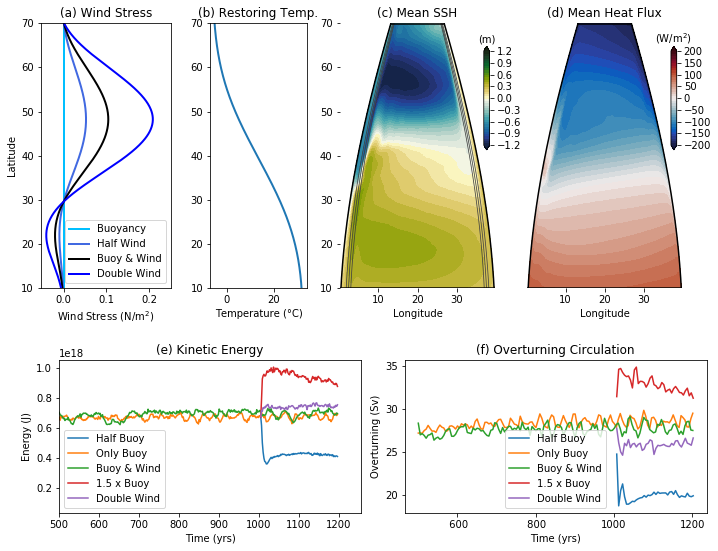

In [278]:
plt.figure(figsize=(10,8))
#(a) Plot wind stress
ax0=plt.axes([0.055, 0.46, 0.18, 0.46])

ax0.plot(0*tau_x_half[:,0],y,label=WindLabel[0],linewidth=2,color=WindColour[0])
ax0.plot(tau_x_half[:,0],y,label=WindLabel[1],linewidth=2,color=WindColour[1])
ax0.plot(tau_x_ref[:,0],y,label=WindLabel[2],linewidth=2,color=WindColour[2])
ax0.plot(tau_x_double[:,0],y,label=WindLabel[3],linewidth=2,color=WindColour[3])

ax0.set_ylim(ymin=10,ymax=70)
ax0.set_xlim(xmax=0.25)
ax0.set_ylabel('Latitude')
ax0.set_xlabel('Wind Stress (N/m$^2$)')
ax0.legend()
ax0.set_title('(a) Wind Stress')


#(b) Plot temp restoring
sst =  38*np.exp((-y/45)**3) - 6

ax0=plt.axes([0.29, 0.46, 0.1344, 0.46])

ax0.plot(sst,y,linewidth=2)
ax0.set_ylim(ymin=10,ymax=70)
ax0.set_xlabel(u'Temperature (°C)')
ax0.set_title('(b) Restoring Temp.')


#(c) Plot topography and SSH
ax0=plt.axes([0.47, 0.46, 0.216, 0.46])

expt = 'tub-north-tx01-fc02'
variable = 'SSH'
FileName = '/Users/andy/Code/buoyancy-gyres/tub-north-processed/'+expt+'/'+variable+'_averaged.nc'
SSH = xr.open_dataset(FileName).SSH
vlev = np.linspace(-1.2,1.2,41)

X,Y = plot_mercator(ax0,SSH.coords['xh'],SSH.coords['yh'])
ax0.contour(X,Y,h,3,colors='0.25',linewidths=0.75)
p1=ax0.contourf(X,Y,SSH,levels=vlev,extend='both',cmap=cm.cm.delta)
ax0.set_title('(c) Mean SSH')
ax1 = plt.axes([0.67,0.7,0.008,0.18])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('(m)')

#(d) Plot Heat Flux
ax0=plt.axes([0.73, 0.46, 0.216, 0.46])

variable = 'heat_added'
FileName = '/Users/andy/Code/buoyancy-gyres/tub-north-processed/'+expt+'/'+variable+'_averaged.nc'
HF = xr.open_dataset(FileName).heat_added
vlev = np.linspace(-200,200,41)

X,Y = plot_mercator(ax0,HF.coords['xh'],HF.coords['yh'])
p1=ax0.contourf(X,Y,HF,levels=vlev,extend='both',cmap=cm.cm.balance)
ax0.set_title('(d) Mean Heat Flux')
ax0.set_yticks([])
ax1 = plt.axes([0.93,0.7,0.008,0.18])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')
ax1.xaxis.set_label_position("top")
cb.ax.set_xlabel('(W/m$^2$)')

##(e) Plot KE evolution
ax0=plt.axes([0.08,0.07,0.42,0.265])
ii=-1
for ekey in Expts:
    ii+=1
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+'KE_timeseries.nc'
    KE = xr.open_dataset(FileName).KE
    KE.groupby_bins('Time',np.arange(0,1200,2)).mean().plot(label=ExptLabels[ii])
plt.legend()
ax0.set_xlim(xmin=500)
ax0.set_ylabel('Energy (J)')
ax0.set_xlabel('Time (yrs)')
ax0.set_title('(e) Kinetic Energy')

#(f) Plot overturning evolution
ax0=plt.axes([0.56,0.07,0.42,0.265])
variable = 'vh_rho'

ii=-1
for ekey in Expts:
    ii+=1
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_overturning_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.sel(Time=slice('0500-01-01','1200-01-01')).resample(Time='5Y').mean().plot(label=ExptLabels[ii])    
#plt.ylim(ymin=0,ymax=36)
plt.legend()

ax0.set_title('(f) Overturning Circulation')
ax0.set_ylabel('Overturning (Sv)')
ax0.set_xlabel('Time (yrs)')

plt.savefig('Figure1.png')
plt.savefig('Figure1.pdf')

# Figure 3

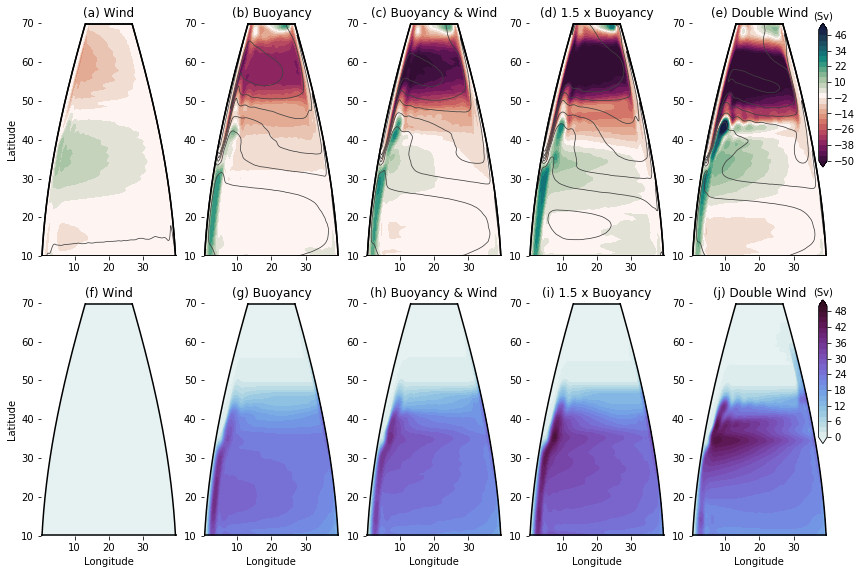

In [153]:
fig, ax = plt.subplots(2,5,figsize=(12,8))
plt.subplots_adjust(bottom=0.06,left=0.05,right=0.96,top=0.95)

ii=-1

vlev = np.linspace(-50,50,26)
tlev = np.linspace(0,30,16)
plev = np.linspace(0,50,26)
for ekey in KeyExpts:
    ii+=1
    expt = exptdict[ekey]['expt']
    
    variable='vh_rho'
    FileName = processed+expt+'/'+variable+'_barotropic_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    
    ax0=ax[0,ii]
    X,Y = plot_mercator(ax0,psi.coords['xh'],psi.coords['yq'])
    p1=ax0.contourf(X,Y,psi,levels=vlev,extend='both',cmap=cm.cm.curl_r)
    ax0.set_title(KeyLabels[ii])
    
    variable = 'temp'
    FileName = processed+expt+'/'+variable+'_surf_averaged.nc'
    SST = xr.open_dataset(FileName).temp
    X,Y = plot_mercator(ax0,SST.coords['xh'],SST.coords['yh'])
    p2=ax0.contour(X,Y,SST,levels=tlev,colors='0.25',linewidths=0.75)
    ax0.set_xlabel('')

    variable='vh_rho'
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho
    
    ax0=ax[1,ii]
    X,Y = plot_mercator(ax0,psi.coords['xh'],psi.coords['yq'])
    p3=ax0.contourf(X,Y,psi,levels=plev,extend='both',cmap=cm.cm.dense)
    ax0.set_title(ekey)
    ax0.set_title(LowerLabels[ii])
    
ax[0,0].set_ylabel('Latitude')
ax[1,0].set_ylabel('Latitude')
ax1 = plt.axes([0.95,0.7,0.01,0.25])
cb = plt.colorbar(p1,cax=ax1,orientation='vertical')#,ticks=[0, 500, 1000, 1500, 2000] )
cb.ax.xaxis.set_label_position("top")
cb.ax.set_xlabel('(Sv)')

ax3 = plt.axes([0.95,0.22,0.01,0.25])
cb = plt.colorbar(p3,cax=ax3,orientation='vertical')#,ticks=[0, 500, 1000, 1500, 2000] )
cb.ax.xaxis.set_label_position("top")
cb.ax.set_xlabel('(Sv)')

plt.savefig('Figure3.png')
plt.savefig('Figure3.pdf')

# Figure 4

-4.870359341473612e-08
-1.6627607912559917e-06
-2.1376403484953253e-06
-2.622562216212476e-06
-3.338688082485036e-06


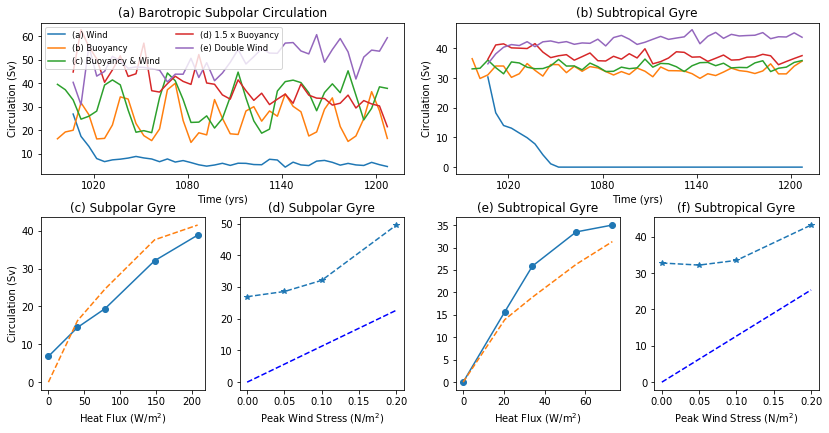

In [307]:
plt.figure(figsize=(12,6))
ax0=plt.axes([0.08,0.6,0.42,0.35])
ii=-1
for ekey in KeyExpts:
    ii+=1
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psimin = -1*xr.open_dataset(FileName).vh_rho
    psimin.resample(Time='5Y').mean().plot(ax=ax0, label=KeyLabels[ii])
    
    
ax0.legend(ncol=2,fontsize='small')
#ax0.set_xlim([0, 150])
ax0.set_title('(a) Barotropic Subpolar Circulation')
ax0.set_xlabel('Time (yrs)')
ax0.set_ylabel('Circulation (Sv)')


ax0=plt.axes([0.56,0.6,0.42,0.35])
ii=-1
for ekey in KeyExpts:
    ii+=1
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_timeseries.nc'
    psi = xr.open_dataset(FileName).vh_rho
    psi.resample(Time='5Y').mean().plot(ax=ax0,label=KeyLabels[ii])  
    
#plt.legend()
#ax0.set_xlim([0, 150])
ax0.set_title('(b) Subtropical Gyre')
ax0.set_xlabel('Time (yrs)')
ax0.set_ylabel('Circulation (Sv)')

ax1=plt.axes([0.08, 0.1, 0.19, 0.4])
ax2=plt.axes([0.31, 0.1, 0.19, 0.4])
ax3=plt.axes([0.56, 0.1, 0.19, 0.4])
ax4=plt.axes([0.79, 0.1, 0.19, 0.4])


FileName = processed+'/'+'heat_added'+'_north_avge.npy'
HeatFluxvec = np.load(FileName)
dyT = xr.open_dataset('../tub-north-processed/ocean_geometry.nc').dyT.values[:,0]
BCvec=np.array([])
spWalin=np.array([])
ii=-1
for ekey in buoy_expts:
    ii+=1
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psi = - xr.open_dataset(FileName).vh_rho.mean()
    BCvec = np.append(BCvec,psi)
    
    FileName = processed+expt+'/temp_surf_averaged.nc'
    SST = xr.open_dataset(FileName).temp
    dTdy = np.gradient(SST.mean('xh').values,1.0)/dyT
    mdTdy = np.mean(dTdy[200:300])
    print(mdTdy)
    spWalin = np.append(spWalin, HeatFluxvec[ii]/(4e6*mdTdy)*np.mean(basin_width[200:300])/1e6)
    
ax1.plot(-HeatFluxvec,BCvec,'o-',label='buoyancy') 
ax1.plot(-HeatFluxvec,spWalin,'--',label='estimate')  
ax1.set_title('(c) Subpolar Gyre')
ax1.set_xlabel('Heat Flux (W/m$^2$)')
ax1.set_ylabel('Circulation (Sv)')



BCvec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_barotropic_min_timeseries.nc'
    psi = - xr.open_dataset(FileName).vh_rho.mean()
    BCvec = np.append(BCvec,psi)
ax2.plot(wind,BCvec,'*--',label='wind')  
ax2.set_title('(d) Subpolar Gyre')
ax2.set_xlabel('Peak Wind Stress (N/m$^2$)')

FileName = processed+'/'+'heat_added'+'_south_avge.npy'
HeatFluxvec = np.load(FileName)
psivec=np.array([])
stWalin=np.array([])
ii=-1
for ekey in buoy_expts:
    ii+=1
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho.sel(xh=10,method='nearest').max()
    psivec = np.append(psivec,psi)
    
    FileName = processed+expt+'/temp_surf_averaged.nc'
    SST = xr.open_dataset(FileName).temp
    dTdy = np.gradient(SST.mean('xh').values,1.0)/dyT
    mdTdy = np.mean(dTdy[80:120])
    stWalin = np.append(stWalin, -HeatFluxvec[ii]/(4e6*mdTdy)*np.mean(basin_width[80:120])/1e6)
    
ax3.plot(HeatFluxvec,psivec,'o-',label='buoyancy')  
ax3.plot(HeatFluxvec,stWalin,'--',label='estimate')  


ax3.set_title('(e) Subtropical Gyre')
ax3.set_xlabel('Heat Flux (W/m$^2$)')

psivec=np.array([])
for ekey in wind_expts:
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/'+variable+'_upper_averaged.nc'
    psi = xr.open_dataset(FileName).vh_rho.sel(xh=10,method='nearest').max()
    psivec = np.append(psivec,psi)
ax4.plot(wind,psivec,'*--',label='wind')
ax4.set_title('(f) Subtropical Gyre')
ax4.set_xlabel('Peak Wind Stress (N/m$^2$)')


## Plot walin-esque buoyancy predictions
#mdTdy = np.mean(dTdy[300:400])
#
#mdTdy = np.mean(dTdy[670:780])
#spWalin[ii] = Bflux_polar[ii]/(4e6*mdTdy)*np.mean(basin_width[600:800])/1e6

# Plot Sverdrup wind predictions
# Calculate Sverdrup vh = ddy(tau_x)/beta
rho0 = 1000


    
tau_x = (0.034*(np.cos(8*np.pi*yp1/180) - 1  + 3.5*np.exp(-((yp1-51.5)/24.2)**2)))*np.tanh((yp1/25))**2
dyF = xr.open_dataset('../tub-north-processed/ocean_geometry.nc').dyCv.values
fCori = xr.open_dataset('../tub-north-processed/ocean_geometry.nc').f
ddy_tau_x = np.gradient(tau_x,1.0)/dyF[:,0]
beta = np.gradient(fCori.isel(lonq=0).values,1.0)/dyF[:,0]
vh = ddy_tau_x/beta/rho0
sverdrup = basin_width*vh/1e6
WindStress=np.array([0.0, 0.5, 1.0, 2.0])
stSv = np.mean(sverdrup[130:170])*WindStress
spSv = -np.mean(sverdrup[270:320])*WindStress
ax2.plot(wind, spSv,'b--',label='Sverdrup')
ax4.plot(wind, stSv,'b--',label='Sverdrup')

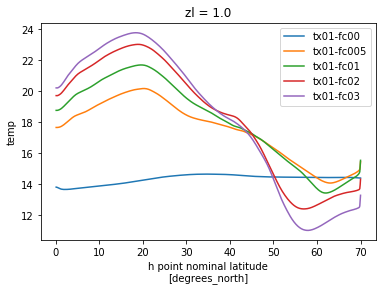

In [298]:
ii=0
for ekey in buoy_expts:
    ii+=1
    expt = exptdict[ekey]['expt']
    FileName = processed+expt+'/temp_surf_averaged.nc'
    SST = xr.open_dataset(FileName).temp
    SST.mean('xh').plot(label=ekey)
    #dTdy = np.gradient(SST.mean('xh').values,1.0)/dyT
    #mdTdy = np.mean(dTdy[80:120])
plt.legend()

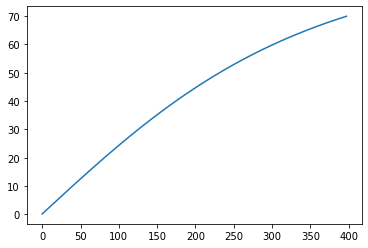

In [301]:
plt.plot(SST.yh.values)

In [287]:
dyT.shape

(398,)

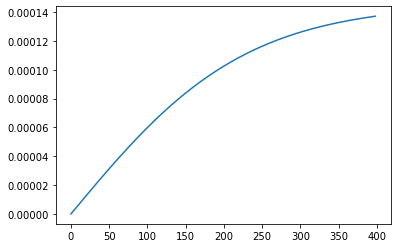

In [213]:
plt.plot(fCori.isel(lonq=0).values)

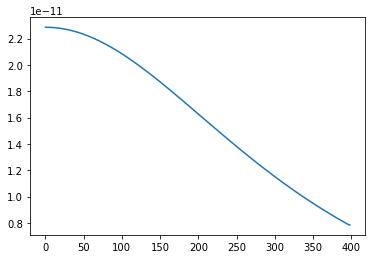

In [214]:
plt.plot(beta)


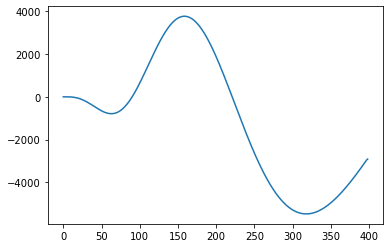

In [216]:
plt.plot(vh)

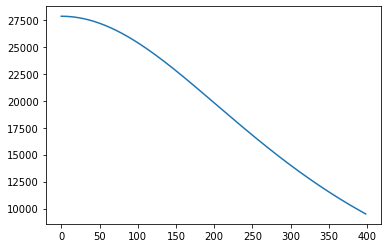

In [217]:
plt.plot(dyF[:,0])